Домашнее задание к лекции "Внимание"
------------------------------------
#### Преподаватель: Даниил Корбут, Алексей Миронов, Екатерина Апраксина, Юлия Пономарева
##### Задание: Решить задачу перевода с помощью механизма внимания
* 1. Возьмите англо-русскую пару фраз (https://www.manythings.org/anki/)
* 2. Обучите на них seq2seq with attention
* *a. На основе скалярного произведения
* *b. На основе MLP
###### Оцените качество

##### Лекционный ноутбук: pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [ ]:
%matplotlib inline

In [86]:
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import tkinter
import time
import math

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv('data/eng-rus.txt', sep='\t', header=None).drop(2, axis=1)
df.head(10)

,0,1
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
5,Hi.,Хай.
6,Hi.,Здрасте.
7,Hi.,Здоро́во!
8,Hi.,Приветик!
9,Run!,Беги!


In [12]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())    
    s = re.sub(r'([.!?])', r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-Я.!?]+", r" ", s)    
    return s


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


MAX_LENGTH = 10
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 444587 sentence pairs
Trimmed to 25903 sentence pairs
Counting words...
Counted words:
rus 9706
eng 4150
['я для этого слишком стара .', 'i m too old for that .']


The Encoder
-----------





In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder (на скалярном произведении)
---------------------------------------

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1,
                 max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length + 2

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        weights = []
        for i in range(len(encoder_outputs)):
            weights.append(
                torch.div(torch.matmul(hidden[0][0], encoder_outputs[i]),
                          torch.sqrt(
                              torch.tensor(self.max_length, dtype=torch.float,
                                           device=device))
                          )
                )
        attn_weights = F.softmax(torch.tensor(weights, device=device))

        attn_applied = torch.bmm(attn_weights.unsqueeze(0).unsqueeze(0),
                                 encoder_outputs.view(1, -1, self.hidden_size)
                                 )

        output = torch.cat((attn_applied[0], embedded[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Функции Обучения и оценки качества

In [15]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [138]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    
    showPlot(plot_losses) 
       
    # return plot_losses

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)        

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [128]:
plt.switch_backend('agg')

def showPlot(losses):
    %matplotlib inline
    plt.figure(figsize=(14,12))
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(losses)
    plt.show()

#### Обучение и оценка качества

8m 5s (- 113m 17s) (5000 6%) 3.0861
16m 22s (- 106m 27s) (10000 13%) 2.5778
24m 31s (- 98m 5s) (15000 20%) 2.2806
32m 44s (- 90m 1s) (20000 26%) 2.1113
40m 51s (- 81m 42s) (25000 33%) 1.9215
49m 6s (- 73m 39s) (30000 40%) 1.7996
57m 15s (- 65m 26s) (35000 46%) 1.6761
65m 23s (- 57m 12s) (40000 53%) 1.6022
73m 36s (- 49m 4s) (45000 60%) 1.4849
81m 49s (- 40m 54s) (50000 66%) 1.3999
90m 8s (- 32m 46s) (55000 73%) 1.3432
98m 34s (- 24m 38s) (60000 80%) 1.2741
107m 4s (- 16m 28s) (65000 86%) 1.2379
115m 14s (- 8m 13s) (70000 93%) 1.1735
123m 29s (- 0m 0s) (75000 100%) 1.1314


<Figure size 1400x1200 with 0 Axes>

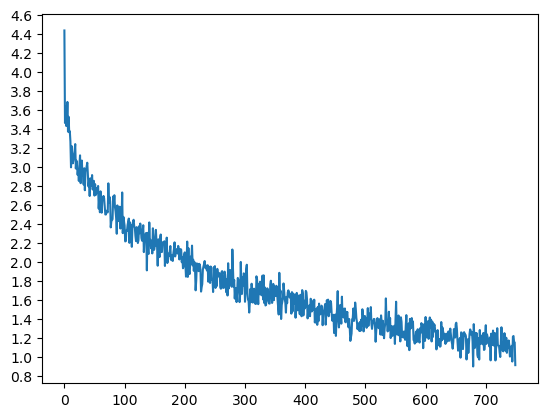

In [140]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [141]:
evaluateRandomly(encoder1, attn_decoder1)

> я нахожусь под большим впечатлением от вашеи работы .
= i m very impressed by your work .
< i m trying to work for work . <EOS>

> она сеичас в гостинице .
= she s at the hotel now .
< she s at the right now . <EOS>

> я только констатирую факты .
= i m just stating facts .
< i m just stating the <EOS>

> она улыбнулась и попрощалась .
= she smiled and said goodbye .
< she smiled and and and . <EOS>

> его уволят .
= he s going to get fired .
< he s stupid . <EOS>

> он так молод .
= he s so young .
< he is so young . <EOS>

> я собираю яблоки .
= i m picking apples .
< i m eating apples . <EOS>

> она определенно удивится .
= she is certain to be surprised .
< she s a brave . <EOS>

> я не уродлив .
= i m not ugly .
< i m not a . <EOS>

> она всегда весела и улыбается .
= she is always cheerful and smiling .
< she is always and and and . <EOS>



<Figure size 1400x1200 with 0 Axes>

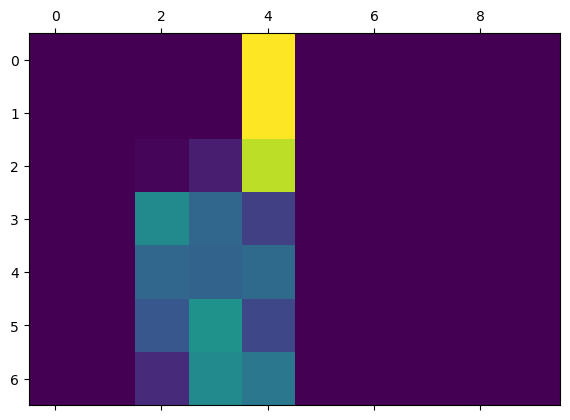

In [147]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "ты хорошии партнер .")
plt.figure(figsize=(14, 12))
plt.matshow(attentions.numpy())
plt.show()

input = прости что заставил тебя волноваться .
output = i m sorry i woke you up . <EOS>


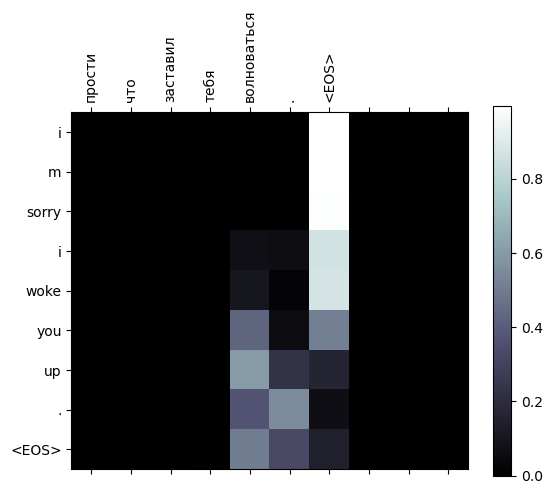

input = он всегда наготове .
output = he s always complaining . <EOS>


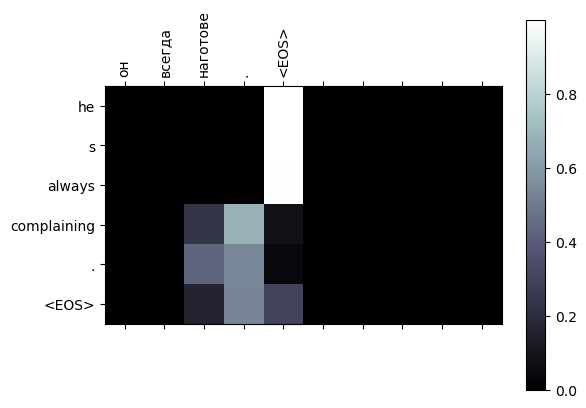

input = он никогда раньше не влюблялся .
output = he never never never in in love . <EOS>


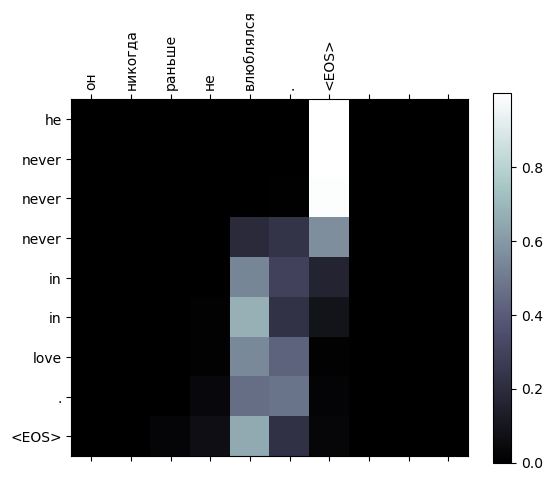

input = она помолвлена с богачом .
output = she s almost tall tall . <EOS>


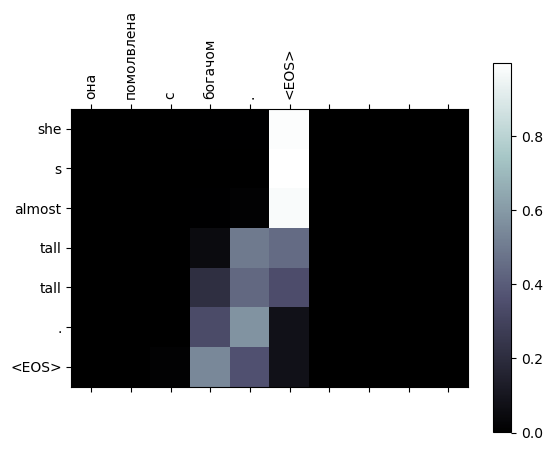

In [148]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("прости что заставил тебя волноваться .")

evaluateAndShowAttention("он всегда наготове .")

evaluateAndShowAttention("он никогда раньше не влюблялся .")

evaluateAndShowAttention("она помолвлена с богачом .")

Attention Decoder (на MLP)
---------------------------

In [153]:
class AttnDecoderRNN_2(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

7m 52s (- 110m 17s) (5000 6%) 3.0587
16m 0s (- 104m 4s) (10000 13%) 2.5493
23m 54s (- 95m 37s) (15000 20%) 2.3181
31m 40s (- 87m 5s) (20000 26%) 2.1102
39m 25s (- 78m 50s) (25000 33%) 1.9603
47m 32s (- 71m 18s) (30000 40%) 1.8460
55m 39s (- 63m 36s) (35000 46%) 1.7198
63m 44s (- 55m 46s) (40000 53%) 1.6574
72m 1s (- 48m 1s) (45000 60%) 1.5632
81m 30s (- 40m 45s) (50000 66%) 1.4765
92m 15s (- 33m 32s) (55000 73%) 1.4102
102m 42s (- 25m 40s) (60000 80%) 1.3586
111m 12s (- 17m 6s) (65000 86%) 1.2996
120m 16s (- 8m 35s) (70000 93%) 1.2895
131m 14s (- 0m 0s) (75000 100%) 1.2098


<Figure size 1400x1200 with 0 Axes>

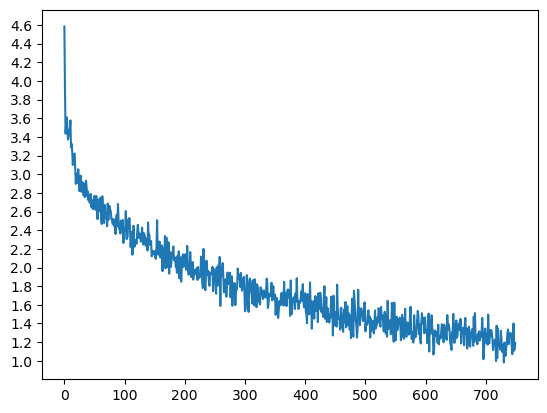

In [154]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN_2(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder1, attn_decoder2, 75000, print_every=5000)

Обучается дольше, чем seq2seq с attention на скалярном произведении (131m 14s против 123m 29s), финальный loss хуже, чем у сети с attention на скалярном произведении (1.2098 против 1.1314).

In [156]:
evaluateRandomly(encoder1, attn_decoder2)

> я выше .
= i am taller .
< i am taller . <EOS>

> ты извращенец .
= you re a pervert .
< you re drunk . <EOS>

> я слабая .
= i am weak .
< i m weak . <EOS>

> они находятся прямо за мнои .
= they re right behind me .
< they re right behind me . <EOS>

> я сегодня не очень хорошо себя чувствую .
= i m not well today .
< i m not feeling very well . <EOS>

> боюсь что ты не можешь поити туда .
= i m afraid you can t go there .
< i m afraid you can t go there . <EOS>

> я в саду .
= i am in the garden .
< i m in the garden . <EOS>

> ты не толстыи .
= you re not fat .
< you re not fat . <EOS>

> ты такои плохои .
= you re so bad .
< you re so bad . <EOS>

> он откладывает деньги на поездку за границу .
= he is saving money for a trip abroad .
< he is living from his money . <EOS>



<Figure size 1400x1200 with 0 Axes>

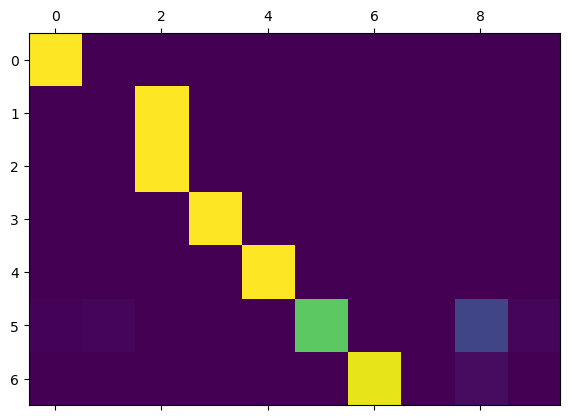

In [157]:
output_words, attentions = evaluate(encoder1, attn_decoder2, "ты хорошии партнер .")
plt.figure(figsize=(14, 12))
plt.matshow(attentions.numpy())
plt.show()

input = прости что заставил тебя волноваться .
output = i m sorry that i you . <EOS>


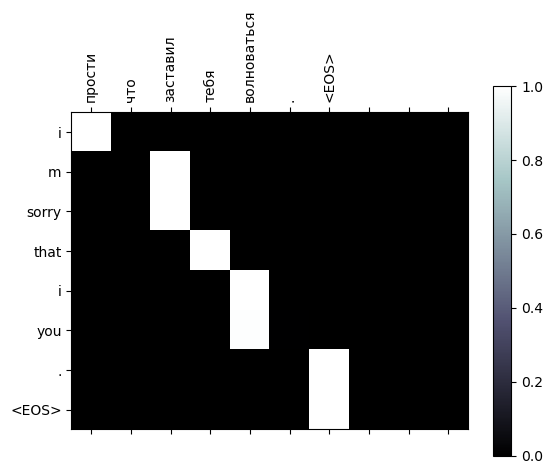

input = он всегда наготове .
output = he s always as an . <EOS>


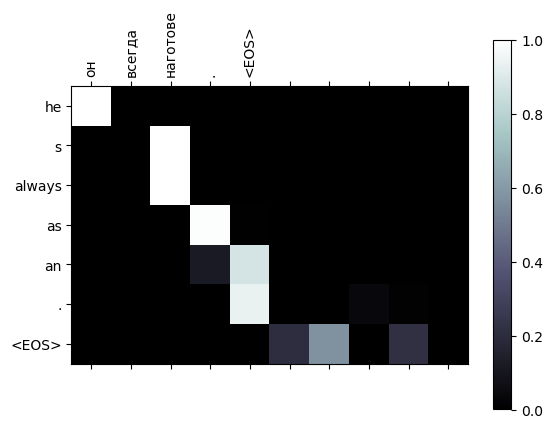

input = он никогда раньше не влюблялся .
output = he s never never to . <EOS>


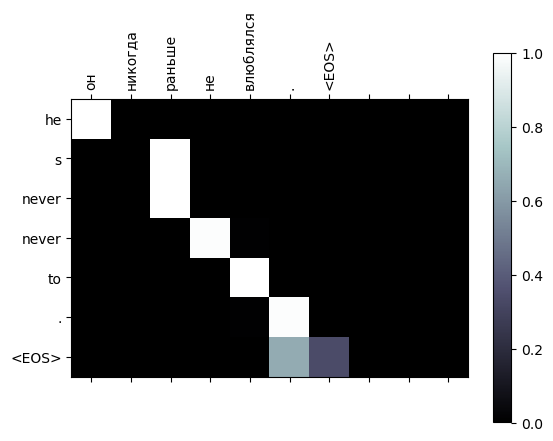

input = она помолвлена с богачом .
output = she is a a a . <EOS>


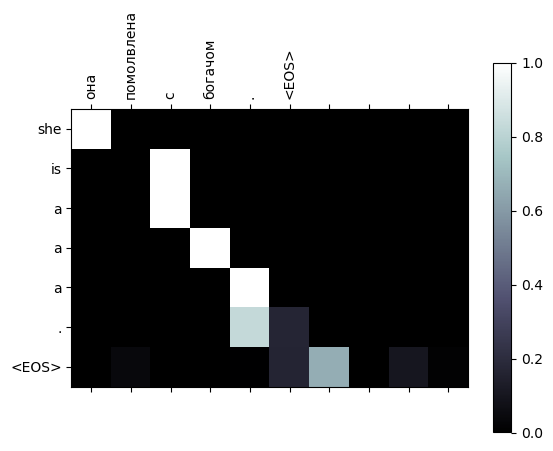

In [160]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("прости что заставил тебя волноваться .")

evaluateAndShowAttention("он всегда наготове .")

evaluateAndShowAttention("он никогда раньше не влюблялся .")

evaluateAndShowAttention("она помолвлена с богачом .")